**Steps for Zero-shot the Model for Cell-Cell Communication:**

1.  **Prepare Your Environment:** Ensure you have the necessary Python libraries installed (as indicated in the original script).
2.  **Download Datasets and Pre-trained Model:** Obtain the gene and protein expression data files for training and testing, as well as the pre-trained model files.
3.  **Organize File Paths:** Make sure the paths to your data files and the pre-trained model are correctly specified.
4.  **Execute the Python Script:** Run the Python script from your terminal, providing the required parameters to control the fine-tuning process.
5.  **Monitor Training (if applicable):** If you are training (`--do_train`), observe the output in your terminal to track the progress (loss, learning rate, etc.).
6.  **Locate Output Files:** After the script finishes, generated feature files and predicted results will be saved in the directory specified by the `--save_dir` parameter (Please download our dataset, generated feature files from https://drive.google.com/drive/folders/1wV8zkBePlZiPpAlAx_xssUkmWYpCzhuT?usp=drive_link).


**Python Command to cell surface protein prediction and imputation:**
```bash
python finetune.py --mode eval --species human --rna_file /home/jiboya/captain/data/rna.h5ad --adt_file False --save_dir /home/jiboya/captain/results --load_model /home/jiboya/captain/model
```

**Explanation of the Command:**
* `--mode`: Sets the script to training or evaluation mode.
* `--species`: Specifies the species of the dataset. Use human or mouse. Default is human.
* `--rna_file`: Required. Provides the path to the RNA data file (e.g., rna.h5ad).
* `--save_dir`: Sets the directory where the training results (model checkpoints, logs, etc.) will be saved. Default is /home/jiboya/captain/results.
* `--load_model`: Optional. Specifies the path to a directory containing a pre-trained model to load for further training or fine-tuning.
* `--seed`: Sets the random seed for reproducibility.
* `--mask_ratio`: Defines the ratio of input data to be masked during training (a common technique in self-supervised learning).
* `--epochs`: Sets the number of times the entire training dataset will be passed through the model during training.
* `--batch_size`: Determines the number of data samples processed together in one batch during training.
* `--lr`: Sets the learning rate, controlling the step size during the optimization process.

Remember to adjust the file paths according to the actual location of your data and pre-trained model. You can also modify other parameters as needed based on your specific requirements.



In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
# import liana as li
import mudata as mu
from matplotlib import pyplot as plt
import scvi

rna = scvi.data.pbmc_dataset(save_path="/home/jiboya/Captain/ccc/zeroshot/data")



In [4]:
import scanpy as sc

rna=sc.read_h5ad("/home/jiboya/Captain/ccc/zeroshot/data/pbmc10k.h5ad")

In [16]:
import scanpy as sc
import omicverse as ov
ov.plot_set()
rna=sc.read_h5ad("/home/jiboya/Captain/ccc/zeroshot/data/pbmc10k.h5ad")
adata=ov.pp.qc(rna,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
               doublets_method='sccomposite',
              batch_key=None)
adata

Dependency error: The 'bioservices' distribution was not found and is required by the application
CPU mode activated
Calculate QC metrics
End calculation of QC metrics.
Original cell number: 11990
!!!It should be noted that the `sccomposite` will remove more cells than             `scrublet`!!!
Begin of post doublets removal and QC plot using `sccomposite`
Cuda is available; Fitting the COMPOSITE model on the RNA modality
Found 8 GPUs available. Using GPU 0         (NVIDIA H800 PCIe) of compute capability 9.        0 with 85.0Gb total memory.

The RNA modality goodness-of-fit score is: 3.579398955493876 
<3: poor fit 
3~5: moderate fit 
>5: good fit
Cells retained after sccomposite: 11224, 766 removed.
End of post sccomposite removal and QC plots.
Filters application (seurat or mads)
Lower treshold, nUMIs: 500; filtered-out-cells:         1
Lower treshold, n genes: 250; filtered-out-cells:         63
Lower treshold, mito %: 0.2; filtered-out-cells:         0
Filters applicated.
Total c

AnnData object with n_obs × n_vars = 11161 × 3345
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'mt', 'n_cells'
    uns: 'cell_types'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

Begin robust gene identification
After filtration, 3345/3345 genes are kept.     Among 3345 genes, 3342 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 2.636864185333252 seconds.
End of size normalization: shiftlog and HVGs selection pearson
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    wit

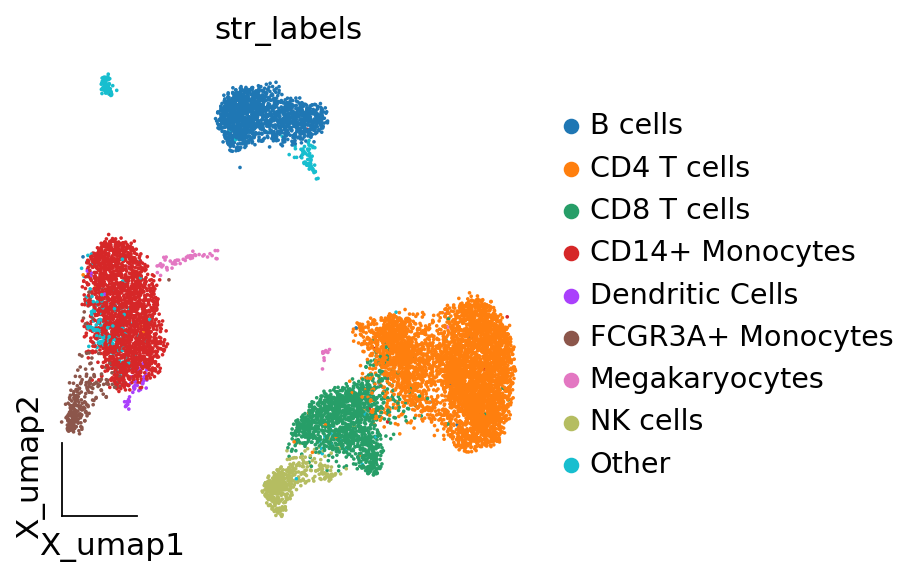

In [17]:

adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,
                       target_sum=50*1e4)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca']

ov.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
ov.pp.umap(adata)
ov.pl.embedding(adata,
                basis='X_umap',
                color='str_labels',
                frameon='small')

In [25]:
import omicverse as ov
import scanpy as sc
#import scvelo as scv
ov.plot_set()
adata = ov.read("/home/jiboya/Captain/ccc/zeroshot/data/pbmc10k_processed.h5ad")
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize = (4,4))
ov.pl.embedding(adata,
                basis='X_umap',
               color='str_labels',
               frameon='small',
               show=False,
                title="celltype",
                save="umap.pdf",
               ax=ax,)


Dependency error: The 'bioservices' distribution was not found and is required by the application


<AxesSubplot: title={'center': 'celltype'}, xlabel='X_umap1', ylabel='X_umap2'>

In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import liana as li
import mudata as mu
from matplotlib import pyplot as plt
rna = sc.read('/home/jiboya/Captain/ccc/zeroshot/data/pbmc10k.h5ad')
rna.var.index=rna.var["gene_symbols"]
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)  

In [10]:
import numpy as np
import anndata as ad
import pandas as pd  
import pickle as pkl
with open('/home/jiboya/Captain/ccc/zeroshot/predicted_adt_data.pickle', 'rb') as fp:
    predicted_adt_data = pkl.load(fp)
# 加载字典和预测数据
with open('/home/jiboya/scBLIP/token_dict/adt_token_dict.pickle', 'rb') as fp:
    adt_token_dict = pkl.load(fp)
predicted_adt_data = np.array(predicted_adt_data)

cont = np.array(predicted_adt_data)


prot = ad.AnnData(
    X=cont,  # 使用新的表达矩阵
    obs=rna.obs.copy(),  # 保留原始的 obs
    obsm=rna.obsm.copy(),  # 保留原始的 obs
    var=pd.DataFrame(index=list(adt_token_dict.keys()))  # 构造新的 var
)

In [11]:
mdata = mu.MuData({'rna': rna, 'prot': prot})
# make sure that cell type is accessible
mdata.obs['celltype'] = mdata.mod['rna'].obs['str_labels'].astype('category')
# inspect the object
mdata

# Obtain a ligand-receptor resource of interest
resource = li.rs.select_resource(resource_name='consensus')
# Append AB: to the receptor names
resource['receptor'] = 'AB:' + resource['receptor']

# Append AB: to the protein modality
mdata.mod['prot'].var_names = 'AB:' + mdata.mod['prot'].var.index

/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [13]:
li.mt.cellphonedb(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,
                    },
                  verbose=True
                  )
mdata.uns['liana_res'].to_csv("/home/jiboya/Captain/ccc/zeroshot/cpdb_res.csv")

Using `.X`!


Using provided `resource`.
Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!


Transforming prot using zi_minmax


Using `.X`!
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.91 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 11990 samples and 77 features


100%|██████████| 1000/1000 [00:03<00:00, 269.27it/s]


In [14]:
li.mt.cellchat(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,

                    },
                  verbose=True
                  )
mdata.uns['liana_res'].to_csv("/home/jiboya/Captain/ccc/zeroshot/cellchat_res.csv")

Using `.X`!


Using provided `resource`.
Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!
Using `.X`!


Transforming prot using zi_minmax


/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.91 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 11990 samples and 77 features


100%|██████████| 1000/1000 [00:20<00:00, 49.67it/s]


In [15]:
li.mt.singlecellsignalr(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,

                    },
                  verbose=True
                  )
mdata.uns['liana_res'].to_csv("/home/jiboya/Captain/ccc/zeroshot/singlecellsignalr_res.csv")


Using `.X`!


Using provided `resource`.
Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!


Transforming prot using zi_minmax


Using `.X`!
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.91 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 11990 samples and 77 features


In [16]:
li.mt.natmi(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,

                    },
                  verbose=True
                  )
mdata.uns['liana_res'].to_csv("/home/jiboya/Captain/ccc/zeroshot/natmi_res.csv")


Using `.X`!


Using provided `resource`.
Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!


Transforming prot using zi_minmax


Using `.X`!
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.91 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 11990 samples and 77 features


In [17]:
li.mt.connectome(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,

                    },
                  verbose=True
                  )
mdata.uns['liana_res'].to_csv("/home/jiboya/Captain/ccc/zeroshot/connectome_res.csv")


Using `.X`!


Using provided `resource`.
Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!
Using `.X`!


Transforming prot using zi_minmax


/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.91 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 11990 samples and 77 features


/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import liana as li
import mudata as mu
from matplotlib import pyplot as plt
# Obtain a ligand-receptor resource of interest
resource = li.rs.select_resource(resource_name='consensus')
# Append AB: to the receptor names
resource['receptor'] = 'AB:' + resource['receptor']
li.mt.cellphonedb(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,

                    },
                  verbose=True
                  )
# mdata.uns['liana_res'].to_csv("/home/jiboya/Captain/ccc7/zeroshot/captain_cpdb_res.csv")

Using provided `resource`.


Using `.X`!


Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!


Transforming prot using zi_minmax


Using `.X`!
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.91 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 11990 samples and 77 features


100%|██████████| 1000/1000 [00:03<00:00, 272.25it/s]


In [38]:
mdata.obs['celltype'].value_counts()

celltype
CD4 T cells          4996
CD14+ Monocytes      2227
B cells              1621
CD8 T cells          1448
Other                 463
NK cells              457
FCGR3A+ Monocytes     351
Dendritic Cells       339
Megakaryocytes         88
Name: count, dtype: int64

In [39]:
mdata.uns['liana_res'] = mdata.uns['liana_res'].rename(columns={'cellphone_pvals': 'captain_pvals'})
from plotnine import theme, element_text
fig =li.pl.dotplot(adata = mdata,
              colour='lr_means',
              size='captain_pvals',
              inverse_size=False, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD4 T cells'],
              target_labels=['CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells','FCGR3A+ Monocytes','Dendritic Cells'],
              figure_size=(6, 6),
              # Filter to top 10 acc to magnitude rank
              top_n=10,
              orderby='captain_pvals',
              orderby_ascending=True,
              cmap='plasma',
              return_fig=True

             )+ theme(axis_text_x=element_text(angle=45, hjust=1))

fig.save(filename="dotplot.pdf", path="/home/jiboya/Captain/ccc/zeroshot", dpi=300)


/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/plotting/_common.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 6 in image.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /home/jiboya/Captain/ccc7/zeroshot/dotplot.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 54 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E

In [2]:

fig =li.pl.circle_plot(mdata,
                  groupby='celltype',
                  score_key='cellphone_pvals',
                  inverse_score=True,
                  source_labels='CD4 T cells',
                  filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
                  pivot_mode='mean', # NOTE: this will simply count the interactions, 'mean' is also available
                  figure_size=(8, 8),
                  )
# Save the plot as a PDF
fig = fig.get_figure()  # Get the Figure object from the Axes

fig.savefig("/home/jiboya/Captain/ccc/zeroshot/circle_plot_CD4T.pdf",dpi=300)
plt.close(fig)

In [31]:
import pandas as pd

LRpairs_filter=pd.read_csv("/home/jiboya/Captain/ccc/zeroshot/captain_cpdb_res.csv",index_col=0)
LRpairs_filter = LRpairs_filter[
    (LRpairs_filter["source"] == "CD4 T cells") &
    (LRpairs_filter["target"] == "Dendritic Cells") &
    (LRpairs_filter["cellphone_pvals"] < 0.05)
]

# LRpairs_filter = LRpairs_filter.sort_values(by="cellphone_pvals", ascending=True).head(100)
cpdb_res=pd.read_csv("/home/jiboya/Captain/ccc/zeroshot/cpdb_res.csv",index_col=0)
cpdb_res = cpdb_res[
    (cpdb_res["source"] == "CD4 T cells") &
    (cpdb_res["target"] == "Dendritic Cells") &
    (cpdb_res["cellphone_pvals"] < 0.05)
]
# cpdb_res = cpdb_res.sort_values(by="cellphone_pvals", ascending=True).head(100)

cellchat_res=pd.read_csv("/home/jiboya/Captain/ccc/zeroshot/cellchat_res.csv",index_col=0)
cellchat_res = cellchat_res[
    (cellchat_res["source"] == "CD4 T cells") &
    (cellchat_res["target"] == "Dendritic Cells") &
    (cellchat_res["cellchat_pvals"] < 0.05)
]
# cellchat_res = cellchat_res.sort_values(by="cellchat_pvals", ascending=True).head(100)
connectome_res=pd.read_csv("/home/jiboya/Captain/ccc/zeroshot/connectome_res.csv",index_col=0)
connectome_res = connectome_res[
    (connectome_res["source"] == "CD4 T cells") &
    (connectome_res["target"] == "Dendritic Cells") &
    (connectome_res["scaled_weight"] > 0.5)
]
# connectome_res = connectome_res.sort_values(by="scaled_weight", ascending=False).head(100)
natmi_res=pd.read_csv("/home/jiboya/Captain/ccc/zeroshot/natmi_res.csv",index_col=0)
natmi_res = natmi_res[
    (natmi_res["source"] == "CD4 T cells") &
    (natmi_res["target"] == "Dendritic Cells") &
    (natmi_res["spec_weight"] > 0.05)
]
# natmi_res = natmi_res.sort_values(by="spec_weight", ascending=False).head(100)
singlecellsignalr_res=pd.read_csv("/home/jiboya/Captain/ccc/zeroshot/singlecellsignalr_res.csv",index_col=0)
singlecellsignalr_res = singlecellsignalr_res[
    (singlecellsignalr_res["source"] == "CD4 T cells") &
    (singlecellsignalr_res["target"] == "Dendritic Cells") &
    (singlecellsignalr_res["lrscore"] > 0.5)
]
# singlecellsignalr_res = singlecellsignalr_res.sort_values(by="lrscore", ascending=False).head(100)

/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/jiboya/anaconda3/envs/linana/lib/python3.9

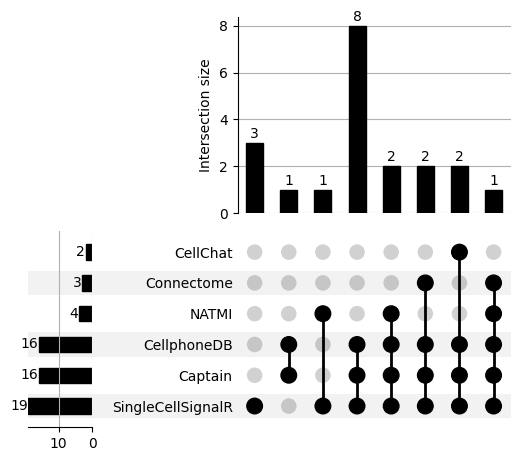

In [37]:
lr_pairs_lrmethod=(LRpairs_filter['ligand_complex'] + LRpairs_filter['receptor_complex']).tolist()
lr_pairs_cpdb = (cpdb_res['ligand_complex'] + cpdb_res['receptor_complex']).tolist()
lr_pairs_cellchat = (cellchat_res['ligand_complex'] + cellchat_res['receptor_complex']).tolist()
lr_pairs_connectome = (connectome_res['ligand_complex'] + connectome_res['receptor_complex']).tolist()
lr_pairs_natmi = (natmi_res['ligand_complex'] + natmi_res['receptor_complex']).tolist()
lr_pairs_singlecellsignalr = (singlecellsignalr_res['ligand_complex'] + singlecellsignalr_res['receptor_complex']).tolist()
(lr_pairs_lrmethod,lr_pairs_cpdb,lr_pairs_cellchat,lr_pairs_connectome,lr_pairs_natmi,lr_pairs_singlecellsignalr)
from upsetplot import from_contents,plot
import matplotlib.pyplot as plt
animals = from_contents(
    {
    'Captain': lr_pairs_lrmethod,
    'CellphoneDB': lr_pairs_cpdb,
    'CellChat': lr_pairs_cellchat,
    'Connectome': lr_pairs_connectome,
    'NATMI': lr_pairs_natmi,
    'SingleCellSignalR': lr_pairs_singlecellsignalr
}
)

from upsetplot import UpSet

ax_dict = UpSet(animals, subset_size="count",show_counts=True).plot()
# 保存为 PDF 文件
plt.savefig("/home/jiboya/Captain/ccc/zeroshot/upset_plot_CD4T_Den.pdf",dpi=300,bbox_inches='tight')